In [0]:
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Conv2D
from keras.models import Model
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.datasets import cifar100
from sklearn.preprocessing import LabelBinarizer

Using TensorFlow backend.


In [0]:
#create train and test splits
(trainX, trainY), (testX, testY) = cifar100.load_data()

trainX = trainX.astype('float32') / 255
testX = testX.astype('float32') / 255

trainX_mean = np.mean(trainX, axis=0)
testX_mean = np.mean(testX, axis=0)
trainX -= trainX_mean
testX -= testX_mean

lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)

169009152/169001437 [==============================] - 6s 0us/step


In [0]:
BS = 128
datagen = ImageDataGenerator(validation_split=0.25)
train_gen = datagen.flow(trainX, trainY, batch_size=BS)
test_gen = datagen.flow(testX, testY, batch_size=BS)

In [0]:
from keras import layers
# from keras import backend as K

In [0]:
# channel_axis = 1 if K.image_data_format() == 'channels_first' else 3
def stem(x):
  x = Conv2D(16, (3,3), strides=(1,1), padding='same')(x)
  x = Conv2D(16, (3,3), padding='same')(x)
  x = Conv2D(32, (3,3), padding='same')(x)
  x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)
  x = Conv2D(40, (1,1), padding='same')(x)
  x = Conv2D(96, (3,3), padding='same')(x)
  x = Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu')(x)
  return x

def incepA(x):
  x0 = Conv2D(16, (1,1))(x)
  x1 = Conv2D(16, (1,1))(x)
  x1 = Conv2D(16, (3,3), padding='same')(x1)
  x2 = Conv2D(16, (1,1))(x)
  x2 = Conv2D(16, (3,3), padding='same')(x2)
  x2 = Conv2D(16, (3,3), padding='same')(x2)
  x3 = layers.Concatenate()([x0, x1, x2])
  x3 = Conv2D(128, (1,1), activation='linear')(x3)
  x3 = layers.add([x, x3])
  x3 = layers.Activation('relu')(x3)
  return x3

def incepB(x):
  x0 = Conv2D(64, (1,1))(x)
  x1 = Conv2D(64, (1,1))(x)
  x1 = Conv2D(64, (1,7), padding='same')(x1)
  x1 = Conv2D(64, (7,1), padding='same')(x1)
  x2 = layers.Concatenate()([x0, x1])
  x2 = Conv2D(448, (1,1), activation='linear')(x2)
  x2 = layers.add([x, x2])
  x2 = layers.Activation('relu')(x2)
  return x2

def incepC(x):
  x0 = Conv2D(96, (1,1))(x)
  x1 = Conv2D(96, (1,1))(x)
  x1 = Conv2D(96, (1,3), padding='same')(x1)
  x1 = Conv2D(96, (3,1), padding='same')(x1)
  x2 = layers.Concatenate()([x0, x1])
  x2 = Conv2D(896, (1,1), activation='linear')(x2)
  x2 = layers.add([x, x2])
  x2 = layers.Activation('relu')(x2)
  return x2


In [0]:
input_shape = trainX[0].shape
inputs = Input(shape=input_shape)
x = stem(inputs)
for i in range(3):
  x = incepA(x)
x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)
x = Conv2D(448, (1,1))(x)

for i in range(3):
  x = incepB(x)
x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)
x = Conv2D(896, (1,1))(x)

for i in range(3):
  x = incepC(x)
# x = layers.AveragePooling2D(pool_size=(3,3), strides=(2,2))(x)
# x = layers.Flatten()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = Dense(100, activation='softmax', kernel_initializer='he_normal')(x)
model = Model(inputs, outputs)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
# compiling model
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.01),
              metrics=['accuracy'])
model.summary()




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 16)   2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 32)   4640        conv2d_2[0][0]                   
__________________________________________________________________________________________

In [0]:
#training
import math
EPOCHS = 75
train_size = len(trainX)
test_size = len(testX)
train_steps = math.ceil(train_size/BS)
valid_steps = math.ceil(test_size/BS)
H = model.fit_generator(train_gen, steps_per_epoch=train_steps,
                        epochs=EPOCHS, validation_data=(testX, testY))
model.save('inceptionresnetmodel.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/75





391/391 [==============================] - 29s 73ms/step - loss: 4.5468 - acc: 0.0165 - val_loss: 4.3773 - val_acc: 0.0351
Epoch 2/75
391/391 [==============================] - 23s 58ms/step - loss: 4.2608 - acc: 0.0474 - val_loss: 4.0795 - val_acc: 0.0840
Epoch 3/75
391/391 [==============================] - 23s 59ms/step - loss: 3.9918 - acc: 0.0842 - val_loss: 3.8831 - val_acc: 0.1076
Epoch 4/75
391/391 [==============================] - 23s 59ms/step - loss: 3.7772 - acc: 0.1170 - val_loss: 3.5798 - val_acc: 0.1568
Epoch 5/75
391/391 [==============================] - 23s 59ms/step - loss: 3.6162 - acc: 0.1456 - val_loss: 3.5038 - val_acc: 0.1670
Epoch 6/75
391/391 [==============================] - 23s 58ms/step - loss: 3.4576 - acc: 0.1725 - val_loss: 3.3275 - val_acc: 0.2025
Epoch 7/75
391/391 [==============================] - 23s 59ms/step - loss: 3.3222 - acc: 0.19

In [0]:
'''EVALUATING THE MODEL'''
scores = model.evaluate(testX, testY, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 2s 187us/step
Test loss: 3.822200273704529
Test accuracy: 0.4727


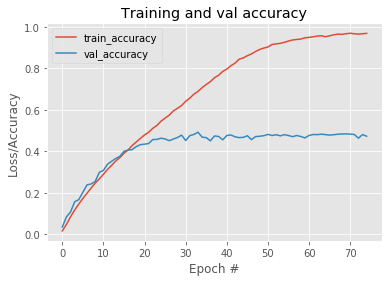

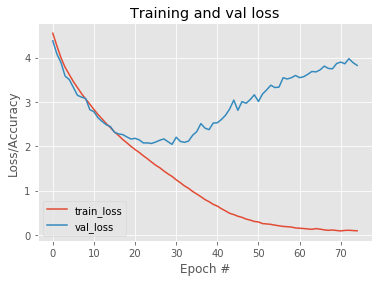

In [0]:
'''PLOT OF ACCURACY AND LOSS WRT EPOCHS'''
from matplotlib import pyplot as plt
N = np.arange(0, EPOCHS)
plt.style.use('ggplot')
plt.figure()

plt.plot(N, H.history['acc'], label='train_accuracy')
plt.plot(N, H.history['val_acc'], label='val_accuracy')
plt.title('Training and val accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='val_loss')
plt.title('Training and val loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [0]:
'''CONFUSION MATRIX'''
from sklearn.metrics import confusion_matrix
predictions = model.predict(testX, batch_size=BS)
print(confusion_matrix(testY.argmax(axis=1), predictions.argmax(axis=1)))

[[74  0  0 ...  0  0  0]
 [ 1 60  0 ...  0  0  0]
 [ 2  1 24 ...  1  0  1]
 ...
 [ 0  1  0 ... 50  0  0]
 [ 1  0  0 ...  2 20  2]
 [ 0  0  0 ...  0  1 55]]


In [0]:
from sklearn.metrics import classification_report
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.56      0.74      0.64       100
           1       0.58      0.60      0.59       100
           2       0.48      0.24      0.32       100
           3       0.29      0.31      0.30       100
           4       0.35      0.36      0.35       100
           5       0.46      0.42      0.44       100
           6       0.54      0.61      0.57       100
           7       0.47      0.46      0.46       100
           8       0.72      0.58      0.64       100
           9       0.59      0.53      0.56       100
          10       0.38      0.21      0.27       100
          11       0.29      0.26      0.27       100
          12       0.45      0.60      0.51       100
          13       0.41      0.33      0.37       100
          14       0.33      0.42      0.37       100
          15       0.43      0.38      0.40       100
          16       0.48      0.54      0.51       100
          17       0.71    